In [1]:
from cebmf_torch.torch_ash import ash
import torch
import numpy as np

import matplotlib.pyplot as plt
 

In [2]:
betahat = torch.tensor([1.,2.,3.,4.,5.])
sebetahat = torch.tensor([1.,0.4,5.,1.,1.])
mult = torch.sqrt(torch.tensor(2.0)).item()
res =  ash(betahat, sebetahat  )
expected_log_lik = -15.244064765169643
expected_scale = np.array([ 0.        , 0.02929687, 0.04143204, 0.05859375, 0.08286408,
                                0.1171875 , 0.16572815, 0.234375  , 0.3314563 , 0.46875   ,
                                0.66291261, 0.9375    , 1.32582521, 1.875     , 2.65165043,
                                3.75      , 5.30330086, 7.5       ])


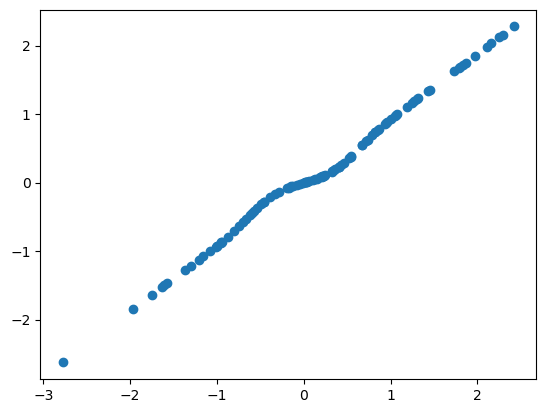

In [3]:
betahat_rand = torch.randn(100)
sebetahat_rand = torch.rand(100) * 0 + .3
res_rand = ash(betahat_rand, sebetahat_rand) 


plt.scatter(betahat_rand,res_rand.post_mean)

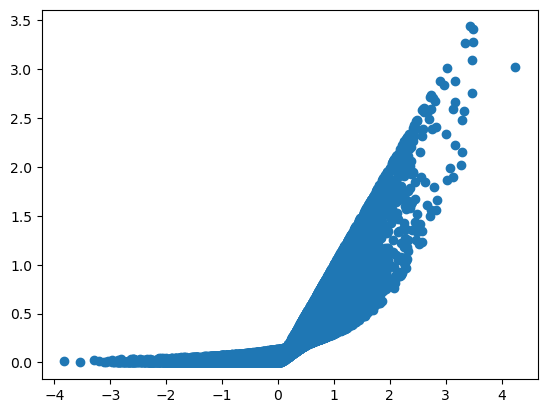

In [4]:
betahat_rand = torch.randn(10000)
sebetahat_rand = torch.abs(torch.rand(10000) )
res_rand = ash(betahat_rand, sebetahat_rand, prior= "exp", batch_size=128) 


plt.scatter(betahat_rand,res_rand.post_mean)

In [5]:
import math
x=betahat
s= sebetahat
mult =math.sqrt(2)
mode=0
penalty=10
verbose=True,
batch_size=100 
shuffle=True 
seed=0

In [6]:
from cebmf_torch.torch_utils_mix import autoselect_scales_mix_exp, autoselect_scales_mix_norm
from cebmf_torch.torch_mix_opt import optimize_pi_logL
from cebmf_torch.torch_utils import _LOG_SQRT_2PI 
from cebmf_torch.torch_posterior import  posterior_mean_norm,  posterior_mean_exp
from cebmf_torch.torch_distribution_operation import get_data_loglik_normal_torch, get_data_loglik_exp_torch

In [7]:
scale = autoselect_scales_mix_norm(x, s, mult=mult)  # (K,)
loc = torch.full((scale.shape[0],), float(mode), dtype=x.dtype, device=x.device)

L = get_data_loglik_normal_torch(x, s, location=loc, scale=scale)  # (J,K)
pi = optimize_pi_logL (
            L, penalty=penalty, verbose=verbose,
            batch_size=batch_size, shuffle=shuffle, seed=seed
        )
log_pi = torch.log(torch.clamp(pi, min=1e-32))

In [8]:
betahat   = torch.as_tensor(betahat)
sebetahat = torch.as_tensor(sebetahat, dtype=betahat.dtype, device=betahat.device)
log_pi    = torch.as_tensor(log_pi, dtype=betahat.dtype, device=betahat.device)
scale     = torch.as_tensor(scale, dtype=betahat.dtype, device=betahat.device)

J = betahat.shape[0]
K = scale.shape[0]

In [9]:
location = None

In [10]:
if location is None:
        location = torch.zeros(K, dtype=betahat.dtype, device=betahat.device)
else:
        location = torch.as_tensor(location, dtype=betahat.dtype, device=betahat.device)
        if location.ndim == 1:
            pass
        elif location.ndim == 2:
            assert location.shape == (J, K), "location must be (K,) or (J,K)"
        else:
            raise ValueError("location must be (K,) or (J,K)")

In [11]:
def apply_log_sum_exp(data_loglik: torch.Tensor, assignment_loglik: torch.Tensor) -> torch.Tensor:
    """
    Row-wise: (L + log_pi) - logsumexp(L + log_pi, axis=1).
    Uses the provided log_sum_exp helper if desired; here we use torch.logsumexp.
    """
    combined = data_loglik + assignment_loglik.unsqueeze(0)  # (J,K)
    norm = torch.logsumexp(combined, dim=1, keepdim=True)    # (J,1)
    return combined - norm    

In [12]:
log_post_assignment = apply_log_sum_exp(L, log_pi) 
resp = torch.exp(log_post_assignment)                                      # (J,K)


In [13]:
s2 = sebetahat.pow(2).unsqueeze(1)     # (J,1)
t2 = scale.pow(2).unsqueeze(0)         # (1,K)

# start with full formula, then patch spike columns where scale==0 -> variance 0
with torch.no_grad():
        denom = (1.0 / s2) + torch.where(t2 > 0, 1.0 / t2, torch.zeros_like(t2))
        t_ind_Var = torch.where(t2 > 0, 1.0 / denom, torch.zeros_like(denom))  # (J,K)

In [14]:
if location.ndim == 1:
        loc = location.unsqueeze(0).expand(J, K)  # (J,K)
else:
        loc = location

m_comp = torch.empty_like(t_ind_Var)
mask_spike = (t2 == 0.0)

In [15]:
t_ind_Var.shape

torch.Size([5, 18])

In [16]:
rhs = t_ind_Var * (
    betahat.unsqueeze(1) / s2 + loc / t2
)  # [J, K]

mask_spike = (t2 == 0.0).expand(J, K)
m_comp = torch.where(mask_spike, loc, rhs)
post_mean  = torch.sum(resp * m_comp, dim=1)
post_mean2 = torch.sum(resp * (t_ind_Var + m_comp.pow(2)), dim=1)
post_sd    = torch.sqrt(torch.clamp(post_mean2 - post_mean.pow(2), min=0.0))

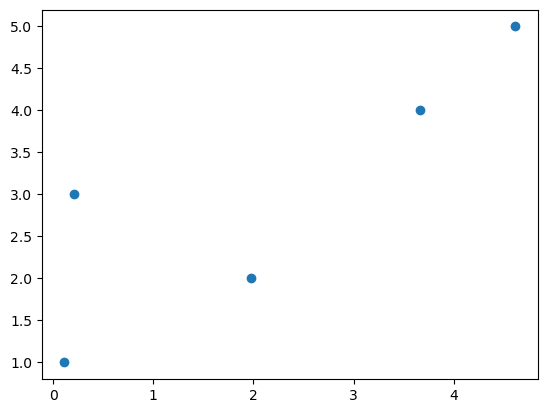

In [17]:
import matplotlib.pyplot as plt 
plt.scatter(post_mean,betahat)

In [18]:
post_mean


tensor([0.1113, 1.9735, 0.2080, 3.6664, 4.6154])

In [19]:
m_comp

tensor([[0.0000e+00, 1.4627e-03, 2.9211e-03, 5.8252e-03, 1.1583e-02, 2.2901e-02,
         4.4776e-02, 8.5714e-02, 1.5789e-01, 2.7273e-01, 4.2857e-01, 6.0000e-01,
         7.5000e-01, 8.5714e-01, 9.2308e-01, 9.6000e-01, 9.7959e-01, 9.8969e-01],
        [0.0000e+00, 1.8144e-02, 3.5963e-02, 7.0655e-02, 1.3649e-01, 2.5554e-01,
         4.5317e-01, 7.3892e-01, 1.0791e+00, 1.4019e+00, 1.6484e+00, 1.8072e+00,
         1.8987e+00, 1.9481e+00, 1.9737e+00, 1.9868e+00, 1.9934e+00, 1.9967e+00],
        [0.0000e+00, 1.7577e-04, 3.5152e-04, 7.0296e-04, 1.4056e-03, 2.8099e-03,
         5.6145e-03, 1.1208e-02, 2.2332e-02, 4.4335e-02, 8.7379e-02, 1.6981e-01,
         3.2143e-01, 5.8065e-01, 9.7297e-01, 1.4694e+00, 1.9726e+00, 2.3802e+00],
        [0.0000e+00, 5.8508e-03, 1.1685e-02, 2.3301e-02, 4.6332e-02, 9.1603e-02,
         1.7910e-01, 3.4286e-01, 6.3158e-01, 1.0909e+00, 1.7143e+00, 2.4000e+00,
         3.0000e+00, 3.4286e+00, 3.6923e+00, 3.8400e+00, 3.9184e+00, 3.9588e+00],
        [0.0000e+00, 7.3

In [20]:
rhs = t_ind_Var * (
    betahat.unsqueeze(1) / s2 + loc / t2
)  # [J, K]

mask_spike = (t2 == 0.0).expand(J, K)
m_comp = torch.where(mask_spike, loc, rhs)

In [21]:
m_comp

tensor([[0.0000e+00, 1.4627e-03, 2.9211e-03, 5.8252e-03, 1.1583e-02, 2.2901e-02,
         4.4776e-02, 8.5714e-02, 1.5789e-01, 2.7273e-01, 4.2857e-01, 6.0000e-01,
         7.5000e-01, 8.5714e-01, 9.2308e-01, 9.6000e-01, 9.7959e-01, 9.8969e-01],
        [0.0000e+00, 1.8144e-02, 3.5963e-02, 7.0655e-02, 1.3649e-01, 2.5554e-01,
         4.5317e-01, 7.3892e-01, 1.0791e+00, 1.4019e+00, 1.6484e+00, 1.8072e+00,
         1.8987e+00, 1.9481e+00, 1.9737e+00, 1.9868e+00, 1.9934e+00, 1.9967e+00],
        [0.0000e+00, 1.7577e-04, 3.5152e-04, 7.0296e-04, 1.4056e-03, 2.8099e-03,
         5.6145e-03, 1.1208e-02, 2.2332e-02, 4.4335e-02, 8.7379e-02, 1.6981e-01,
         3.2143e-01, 5.8065e-01, 9.7297e-01, 1.4694e+00, 1.9726e+00, 2.3802e+00],
        [0.0000e+00, 5.8508e-03, 1.1685e-02, 2.3301e-02, 4.6332e-02, 9.1603e-02,
         1.7910e-01, 3.4286e-01, 6.3158e-01, 1.0909e+00, 1.7143e+00, 2.4000e+00,
         3.0000e+00, 3.4286e+00, 3.6923e+00, 3.8400e+00, 3.9184e+00, 3.9588e+00],
        [0.0000e+00, 7.3

In [22]:
betahat

tensor([1., 2., 3., 4., 5.])

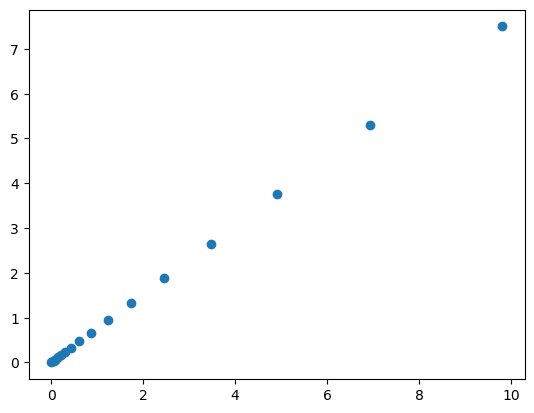

In [23]:
plt.scatter( res.scale.cpu().numpy(), expected_scale)

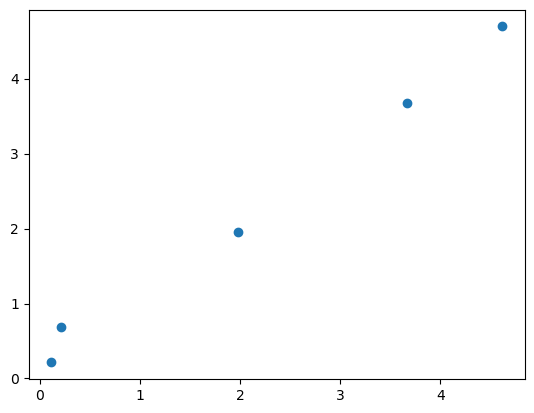

In [24]:
plt.scatter(res.post_mean.cpu().numpy(), np.array([0.21361966, 1.95003336, 0.68125659, 3.67773689, 4.69599116]))

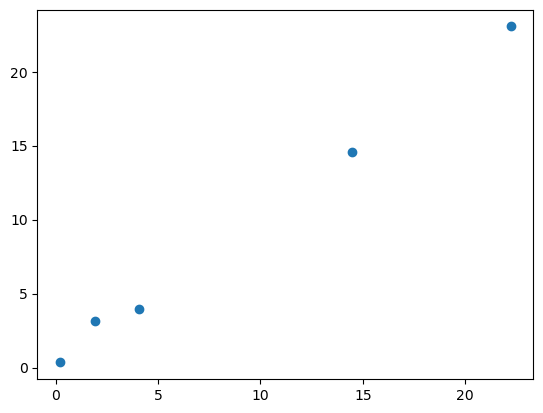

In [25]:
plt.scatter(res.post_mean2.cpu().numpy(), np.array([ 0.34021317,  3.96295414,  3.17114472, 14.58222929, 23.05642398]))

In [26]:
res.log_lik 

-16.917675018310547

In [27]:
expected_log_lik

-15.244064765169643

In [28]:
betahat = torch.tensor([1.,2.,3.,4.,5.])
sebetahat = torch.tensor([1.,0.4,5.,1.,1.]) 

In [29]:
scale = autoselect_scales_mix_exp(betahat, sebetahat)

In [30]:
L = get_data_loglik_exp(betahat, sebetahat,   scale)
L

NameError: name 'get_data_loglik_exp' is not defined

In [ ]:
pi = optimize_pi_logL_torch(L, penalty=10, method="em", steps=5000, batch_size=5)

NameError: name 'optimize_pi_logL_torch' is not defined

In [ ]:
out = posterior_mean_exp(betahat, sebetahat, torch.log(pi+1e-32), scale)

In [ ]:
result = torch.exp(L) * torch.exp(pi)

In [ ]:
cembf_torc 